# Day 3 - EAST Text Detection Demo ##
### Objective: Showcase Real-time EAST Text Detection (Efficient and Accurate Scene Text Detector)

#### Section 1 - Dependencies & Libraries

In [ ]:
# Install required libraries
!pip3 install numpy matplotlib imutils opencv-python opencv-contrib-python

# Restart Kernel Manually
# Toolbar -> Kernel -> Restart & Clear Output -> Restart & Clear All Outputs

In [1]:
# Import required libraries
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import numpy as np, time, cv2

#### Section 2 -  Build EAST Text Detector Class

In [2]:
# Define text_detection class
class text_detection(object):
    
    # Define Initialiation Function - Height and Width need to be multiples of 32
    def __init__(self, default_height=1024, default_width=1024, min_confidence=0.5):
        # Load Frozen EAST FCN
        self.model = cv2.dnn.readNet("frozen_east_text_detection.pb")
        # Define EAST Output Layers
        self.output = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
        # Store Default Width and Height
        self.height, self.width, self.min_confidence = default_height, default_width, min_confidence
    
    # Define private function to pre-process image (resizing and turning to opencv blob)
    def __preprocess_image(self, img):
        # Resize image to default height & Width
        img = cv2.resize(img, (self.width, self.height))
        # Calculate image blob using cv2.dnn.blobFromImage
        return cv2.dnn.blobFromImage(img, 1.0, (self.width, self.height), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    # Define private function to parse EAST results into list of boudning box coorindates and list of confidences
    def __parse_results(self, scores, geometry):
        (numRows, numCols) = scores.shape[2:4]
        rects = []
        confidences = []
        for y in range(0, numRows):
            for x in range(0, numCols):
                # Only consider bounding boxes with confidence > min_confidence
                if scores[0, 0, y][x] >= self.min_confidence:
                    #  Compute the sin and cosine of the rotation angle
                    cos = np.cos(geometry[0, 4, y][x])
                    sin = np.sin(geometry[0, 4, y][x])
                    # Calculate the height and Width of the bounding box
                    h = geometry[0, 0, y][x] + geometry[0, 2, y][x]
                    w = geometry[0, 1, y][x] + geometry[0, 3, y][x]
                    # Compute both the starting and ending (x, y)-coordinates for bounding box
                    endX = int((x * 4.0) + (cos * geometry[0, 1, y][x]) + (sin * geometry[0, 2, y][x]))
                    endY = int((y * 4.0) - (sin * geometry[0, 1, y][x]) + (cos * geometry[0, 2, y][x]))
                    startX = int(endX - w)
                    startY = int(endY - h)
                    # Append bounding box coordinates and confidence to respective arrays
                    rects.append((startX, startY, endX, endY))
                    confidences.append(scores[0, 0, y][x])
        return rects, confidences
    
    # Define private function to draw boxes on image using cv2.rectangle
    def __draw_boxes(self, img, boxes):
        for (startX, startY, endX, endY) in boxes:
            # Calculate scale factors (ratio of original image to resized image)
            rW = img.shape[1] / float(self.width)
            rH = img.shape[0] / float(self.height)
            # Draw the bounding box on the image
            cv2.rectangle(img, (int(startX * rW), int(startY * rH)), (int(endX * rW), int(endY * rH)), (0, 255, 0), 2)
        return img

    # Define function to detect text boxes in image and return image with drawn text boxes
    def detect(self, img):
        self.model.setInput(self.__preprocess_image(img))
        scores, geometry = self.model.forward(self.output)
        rects, confidences = self.__parse_results(scores, geometry)
        boxes = non_max_suppression(np.array(rects), probs=confidences)
        return self.__draw_boxes(img, boxes)

#### Section 3 -  Test Text Detector on hadwritten_arabic.jpg

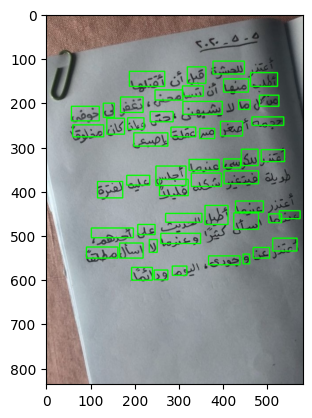

In [14]:
# Initialize the Text Detector
text_detector = text_detection(1024, 1024)
# Load Image
image = cv2.imread("handwritten_arabic.jpg")
# Detect Boxes
image_with_boxes = text_detector.detect(image)
# Draw Image with Boxes
plt.imshow(image_with_boxes)

#### Section 4 -  Real-time Text Detection on Camera Feed

In [ ]:
# Open Default Camera Using Opencv
vid = cv2.VideoCapture(0)

# While True (Interrupt by pressing q)
while(True):
    # Capture the video frame
    ret, frame = vid.read()
    #image = cv2.imread("handwritten_arabic.jpg")
    image_with_boxes = text_detector.detect(frame)
    # Display the resulting frame
    cv2.imshow('frame', image_with_boxes)
    # the 'q' button is set as the quitting button
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
# Destroy all the windows
cv2.destroyAllWindows()